In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils

class AttentionLayer(nn.Module):
    """Basic attention mechanism for sequence processing"""
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.W = nn.Linear(input_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)

    def forward(self, lstm_output, mask=None):
        att_scores = self.V(torch.tanh(self.W(lstm_output))).squeeze(-1)
        
        if mask is not None:
            att_scores = att_scores.masked_fill(mask == 0, -1e9)
            
        att_weights = F.softmax(att_scores, dim=1)
        context = (lstm_output * att_weights.unsqueeze(-1)).sum(1)
        return context, att_weights

class CNNLSTM(nn.Module):
    """Modular video action classifier with various configuration options"""
    def __init__(self, num_classes, 
                 lstm_hidden_size=512,
                 lstm_layers=1,
                 dropout=0.5,
                 freeze_cnn=True,
                 use_attention=False,
                 cnn_model='resnet18'):
        
        super().__init__()
        self.cnn_feature_size = 512  # Default for ResNet18
        self.use_attention = use_attention

        # CNN Feature Extractor
        self.cnn, self.cnn_feature_size = self._build_cnn(cnn_model)
        self._set_cnn_freeze(freeze_cnn)

        # Sequence Processing
        self.lstm = nn.LSTM(
            input_size=self.cnn_feature_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            # bidirectional=True,
            dropout=dropout if lstm_layers > 1 else 0
        )

        # Attention Mechanism
        if self.use_attention:
            self.attention = AttentionLayer(
                input_size=lstm_hidden_size*2, 
                hidden_size=lstm_hidden_size
            )

        # Classification Head
        self.classifier = self._build_classifier(
            lstm_hidden_size*1, 
            num_classes, 
            dropout
        )

        # Initialize weights
        self._initialize_weights()

    def _build_cnn(self, model_name):
        """Initialize CNN feature extractor"""
        if model_name == 'resnet18':
            cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            return nn.Sequential(*list(cnn.children())[:-2]), 512  # Remove avgpool and fc
        else:
            raise ValueError(f"Unsupported CNN model: {model_name}")

    def _build_classifier(self, input_size, num_classes, dropout):
        """Build modular classification head"""
        return nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            
            nn.Linear(128, num_classes)
        )

    def _initialize_weights(self):
        """Initialize weights for classification layers"""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _set_cnn_freeze(self, freeze):
        """Freeze/unfreeze CNN parameters"""
        for param in self.cnn.parameters():
            param.requires_grad = not freeze

    def forward(self, x, lengths):
        # Process frames through CNN
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(batch_size*seq_len, *x.size()[2:])
        x = self.cnn(x)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(batch_size, seq_len, -1)

        # Process sequence through LSTM
        packed_x = rnn_utils.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, _ = self.lstm(packed_x)
        lstm_out, _ = rnn_utils.pad_packed_sequence(packed_out, batch_first=True)

        # Get final representation
        if self.use_attention:
            mask = self._create_attention_mask(lstm_out.size(1), lengths)
            context, _ = self.attention(lstm_out, mask)
        else:
            # Get last valid time step output
            context = lstm_out[torch.arange(batch_size), lengths-1, :]

        return self.classifier(context)

    def _create_attention_mask(self, max_len, lengths):
        """Create attention mask from sequence lengths"""
        device = lengths.device
        return torch.arange(max_len, device=device).expand(len(lengths), max_len) < lengths.unsqueeze(1)

    def unfreeze_cnn_layers(self, num_layers=3, start_from_end=True):
        """Gradually unfreeze CNN layers for fine-tuning"""
        conv_layers = [m for m in self.cnn.modules() if isinstance(m, nn.Conv2d)]
        num_total = len(conv_layers)
        
        if start_from_end:
            layers_to_unfreeze = conv_layers[-num_layers:]
        else:
            layers_to_unfreeze = conv_layers[:num_layers]
            
        for layer in layers_to_unfreeze:
            for param in layer.parameters():
                param.requires_grad = True

    def count_parameters(self):
        total_params = 0
        for name, parameter in self.named_parameters():
            if parameter.requires_grad:
                params = parameter.numel()
                print(f"{name}: {params}")
                total_params += params
        print(f"Total Trainable Params: {total_params}")

In [2]:
# Create dummy data for testing
batch_size = 2
seq_len = 10
channels = 3
height = 224
width = 224

# Random input tensor with shape (batch_size, seq_len, channels, height, width)
dummy_input = torch.randn(batch_size, seq_len, channels, height, width)

# Random sequence lengths between 5 and 10
dummy_lengths = torch.randint(5, seq_len+1, (batch_size,))
print(dummy_lengths)
# Test the model
model = CNNLSTM(num_classes=13)
output = model(dummy_input, dummy_lengths)

print(f"Input shape: {dummy_input.shape}")
print(f"Sequence lengths: {dummy_lengths}")
print(f"Output shape: {output.shape}")


tensor([7, 5])
Input shape: torch.Size([2, 10, 3, 224, 224])
Sequence lengths: tensor([7, 5])
Output shape: torch.Size([2, 13])


In [3]:
model.count_parameters()

lstm.weight_ih_l0: 1048576
lstm.weight_hh_l0: 1048576
lstm.bias_ih_l0: 2048
lstm.bias_hh_l0: 2048
classifier.0.weight: 262144
classifier.0.bias: 512
classifier.1.weight: 512
classifier.1.bias: 512
classifier.4.weight: 131072
classifier.4.bias: 256
classifier.5.weight: 256
classifier.5.bias: 256
classifier.8.weight: 32768
classifier.8.bias: 128
classifier.9.weight: 128
classifier.9.bias: 128
classifier.12.weight: 1664
classifier.12.bias: 13
Total Trainable Params: 2531597


In [4]:
model

CNNLSTM(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [97]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms.v2 as T
import random

class VideoAugmentationPipeline:
    """Video augmentation pipeline using batch transforms from torchvision.transforms.v2"""
    def __init__(self, spatial_aug_config=None, temporal_aug_config=None):
        # Default config with all augmentations enabled
        default_spatial_config = {
            'random_resized_crop': {'enabled': False, 'scale': (0.9, 1.0)},
            'random_horizontal_flip': {'enabled': True, 'p': 0.5},
            'color_jitter': {'enabled': True, 'brightness': 0.1, 'contrast': 0.1, 'saturation': 0.1, 'p': 0.5},
            'gaussian_blur': {'enabled': True, 'p': 0.5},
            'random_rotation': {'enabled': True, 'degrees': (-5, 5),'p':0.5},
        }

        default_temporal_config = {
            'temporal_crop': {'enabled': True, 'crop_size': 0.9},
            'temporal_mask': {'enabled': True, 'n_masks': 1, 'mask_size': 0.1},
        }

        # Update default config with user-provided config
        self.spatial_aug_config = self._update_config(default_spatial_config, spatial_aug_config)
        self.temporal_aug_config = self._update_config(default_temporal_config, temporal_aug_config)

        # Build transforms that can handle batch inputs
        self.spatial_transforms = self._build_spatial_transforms()

    def _update_config(self, default_config, user_config):
        """Update default config with user config, disabling augmentations not in user config"""
        if user_config is None:
            return default_config
            
        updated_config = default_config.copy()
        for aug_name in updated_config:
            if aug_name in user_config:
                # # Update probability if provided
                # if isinstance(user_config[aug_name], dict):
                #     updated_config[aug_name].update(user_config[aug_name])
                # else:
                    updated_config[aug_name]['p'] = user_config[aug_name]
            else:
                # Disable augmentation if not in user config
                updated_config[aug_name]['enabled'] = False
        return updated_config

    def _build_spatial_transforms(self):
        """Build composition of spatial transforms that support batch processing"""
        transform_list = []

        if self.spatial_aug_config['random_resized_crop']['enabled']:
            transform_list.append(
                T.RandomResizedCrop(
                    size=(224, 224),
                    scale=self.spatial_aug_config['random_resized_crop']['scale'],
                    antialias=True
                )
            )

        if self.spatial_aug_config['random_horizontal_flip']['enabled']:
            transform_list.append(
                T.RandomHorizontalFlip(p=self.spatial_aug_config['random_horizontal_flip']['p'])
            )

        if self.spatial_aug_config['color_jitter']['enabled']:
            transform_list.append(
                T.ColorJitter(
                    brightness=self.spatial_aug_config['color_jitter']['brightness'],
                    contrast=self.spatial_aug_config['color_jitter']['contrast'],
                    saturation=self.spatial_aug_config['color_jitter']['saturation']
                )
            )

        if self.spatial_aug_config['gaussian_blur']['enabled']:
            transform_list.append(
                T.GaussianBlur(
                    kernel_size=(5, 5),
                    sigma=(0.1, 1.0)
                )
            )

        if self.spatial_aug_config['random_rotation']['enabled']:
            if random.random() < self.spatial_aug_config['random_rotation']['p']:
                transform_list.append(
                    T.RandomRotation(
                        degrees=self.spatial_aug_config['random_rotation']['degrees'],
                        interpolation=T.InterpolationMode.BILINEAR
                    )
                )

        return T.Compose(transform_list)

    def apply_temporal_augmentation(self, video_tensor):
        """Apply temporal augmentations to video tensor"""
        if not any(cfg['enabled'] for cfg in self.temporal_aug_config.values()):
            return video_tensor

        T, C, H, W = video_tensor.shape

        # Temporal crop
        if self.temporal_aug_config['temporal_crop']['enabled']:
            crop_size = int(T * self.temporal_aug_config['temporal_crop']['crop_size'])
            start_idx = random.randint(0, T - crop_size)
            video_tensor = video_tensor[start_idx:start_idx + crop_size]

        # Temporal masking
        if self.temporal_aug_config['temporal_mask']['enabled']:
            T = len(video_tensor)
            mask_size = int(T * self.temporal_aug_config['temporal_mask']['mask_size'])
            for _ in range(self.temporal_aug_config['temporal_mask']['n_masks']):
                if random.random() < 0.5:
                    start_idx = random.randint(0, T - mask_size)
                    video_tensor[start_idx:start_idx + mask_size] = 0

        return video_tensor

    def __call__(self, video_tensor):
        """Apply transforms to entire video tensor at once"""
        # Input shape: [T, C, H, W]
        # Reshape to [T, C, H, W] -> [1, T, C, H, W] for batch processing
        video_tensor = video_tensor.unsqueeze(0)

        # Apply spatial transforms to entire video tensor at once
        # transforms.v2 will maintain temporal consistency automatically
        video_tensor = self.spatial_transforms(video_tensor)

        # Remove batch dimension
        video_tensor = video_tensor.squeeze(0)

        # Apply temporal augmentations
        # video_tensor = self.apply_temporal_augmentation(video_tensor)

        return video_tensor

In [98]:
spatial_aug_config = {
    'gaussian_blur': 0.5,
    'random_horizontal_flip':  0.5,
    'color_jitter': 0.5,
    'random_rotation': 0.5
}

temporal_aug_config = {
    'temporal_crop': {'enabled': True, 'crop_size': 0.8},
    'temporal_mask': {'enabled': True, 'mask_size': 0.2, 'n_masks': 2}
}

# Initialize augmentation pipeline
augmentation_pipeline = VideoAugmentationPipeline(
    spatial_aug_config=spatial_aug_config,
    temporal_aug_config=temporal_aug_config
)

print(augmentation_pipeline.spatial_transforms)

Compose(
      RandomHorizontalFlip(p=0.5)
      ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1))
      GaussianBlur(kernel_size=(5, 5), sigma=[0.1, 1.0])
      RandomRotation(degrees=[-5.0, 5.0], interpolation=InterpolationMode.BILINEAR, expand=False, fill=0)
)


In [99]:
import os
import torch
import pandas as pd
import numpy as np
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import imageio
import random
FRAME_HEIGHT = 224
FRAME_WIDTH = 224
SEQUENCE_LENGTH = 10

class YogaVideoDataset(Dataset):
    def __init__(self, csv_path, sequence_path, pose_list, video_dir, preprocessed_dir,
                 spatial_aug_config=None, temporal_aug_config=None, use_augmentation=True, aug_ratio = 0.5):
        with open(sequence_path) as f:
            sequence_list = f.read().splitlines()
            sequence_list = [int(x) for x in sequence_list]

        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df['sequence_id'].isin(sequence_list)]
        self.df = self.df[self.df['l3_pose'].isin(pose_list)]

        self.pose_to_idx = {pose: idx for idx, pose in enumerate(pose_list)}
        self.length_of_dataset = len(self.df)

        self.video_dir = video_dir
        self.preprocessed_dir = preprocessed_dir
        os.makedirs(self.preprocessed_dir, exist_ok=True)

        # Initialize augmentation pipeline
        self.augmentation_pipeline = VideoAugmentationPipeline(
            spatial_aug_config=spatial_aug_config,
            temporal_aug_config=temporal_aug_config
        )

        self.cache = dict()
        self.augmentation_ratio = aug_ratio
        self.use_augmentation = use_augmentation
        
        self.transforms = transforms.Compose([
            transforms.Resize((FRAME_HEIGHT, FRAME_WIDTH)),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                      std=[0.229, 0.224, 0.225])
        ])
        self.normalization = transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    def __len__(self):
        return self.length_of_dataset

    def __getitem__(self, i):
        sequence_id = self.df.iloc[i]['sequence_id']
        pose = self.df.iloc[i]['l3_pose']
        label = self.pose_to_idx[pose]

        # Load preprocessed frames
        if sequence_id in self.cache:
            frames = self.cache[sequence_id]
        else:
            file_path = os.path.join(self.preprocessed_dir, f"{sequence_id}.pt")
            if not os.path.exists(file_path):
                video_path = os.path.join(self.video_dir, f"{sequence_id}.mp4")
                frames = self._get_frames(video_path)
                torch.save(frames, file_path)
            else:
                frames = torch.load(file_path, weights_only=True)
            self.cache[sequence_id] = frames

        # Choose whether to use augmented or original data
        use_augmented_data = self.use_augmentation and self.augmentation_ratio < random.random()
        if use_augmented_data:
            frames = self.augmentation_pipeline(frames)
        
        frames = self.normalization(frames)
        return frames, label

    def _get_frames(self, video_path, sequence_length = SEQUENCE_LENGTH):
        reader = imageio.get_reader(video_path, 'ffmpeg')
        fps = imageio.get_reader(video_path, 'ffmpeg').get_meta_data()['fps'] // 1
        total_frames = reader.count_frames()

        indices = np.arange(0, fps - 1, fps // SEQUENCE_LENGTH, dtype=int)

        # print(indices)
        frames = []
        for i, frame in enumerate(reader):
            if i % fps in indices:
                frame = Image.fromarray(frame)
                frame = self.transforms(frame)
                frames.append(frame)
                # print('Frame number', i % fps, 'Frame', i)

        reader.close()
        # print('Frame Length', len(frames))
        frames = torch.stack(frames)
        return frames

In [100]:
import os
# Get current working directory
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# Setup path to shorts directory
base_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(current_dir))))
shorts_dir = os.path.join(base_dir, 'short')
print(shorts_dir)
# List contents of shorts directory
print("\nContents of shorts directory:")
import os
print(os.listdir(shorts_dir))


Current working directory: c:\Users\aagab\codes\Human_pose\new_statistical_coach\src\model\2D_CNN_LSTM
c:\Users\aagab\codes\Human_pose\short

Contents of shorts directory:
['1000.mp4', '1002.mp4', '1003.mp4', '1004.mp4', '1005.mp4', '1006.mp4', '1007.mp4', '1008.mp4', '1009.mp4', '1010.mp4', '1011.mp4', '1012.mp4', '1013.mp4', '1014.mp4', '1015.mp4', '1016.mp4', '1017.mp4', '1018.mp4', '1020.mp4', '1021.mp4', '1022.mp4', '1023.mp4', '1024.mp4', '1025.mp4', '1026.mp4', '1027.mp4', '1028.mp4', '1029.mp4', '1030.mp4', '1031.mp4', '1032.mp4', '1033.mp4', '1034.mp4', '1035.mp4', '1036.mp4', '1037.mp4', '1038.mp4', '1039.mp4', '1040.mp4', '1041.mp4', '1042.mp4', '1043.mp4', '1044.mp4', '1045.mp4', '1046.mp4', '1047.mp4', '1048.mp4', '1049.mp4', '1050.mp4', '1053.mp4', '1054.mp4', '1055.mp4', '1056.mp4', '1057.mp4', '1058.mp4', '1059.mp4', '1060.mp4', '1062.mp4', '1063.mp4', '1064.mp4', '1065.mp4', '1066.mp4', '1067.mp4', '1068.mp4', '1069.mp4', '1070.mp4', '1071.mp4', '1072.mp4', '1073.mp4',

In [101]:
base_path = base_dir
base_path

'c:\\Users\\aagab\\codes\\Human_pose'

In [102]:
import os

# Gets label
csv_path = os.path.join(base_path,'data/3DYoga90_corrected.csv')

# Gets valid samples
sequence_path = os.path.join(base_path, 'short/downloaded_log.txt')

# Path to save the model
save_path = os.path.join(base_path, 'FEB_10_unknown_attention')
os.makedirs(save_path, exist_ok=True)

# Classification classes
pose_list = ['mountain', 'half-way-lift', 'standing-forward-bend', 'downward-dog']
NUM_CLASSES = len(pose_list)

# Original Downloaded Seqeuence
video_dir = os.path.join(base_path, 'short')

# Pre_processed to tensor to make training fast # Makes video_dir redundant
preprocessed_dir = os.path.join(base_path, 'complete_pre_processed')
os.makedirs(preprocessed_dir, exist_ok=True)
assert os.path.isdir(preprocessed_dir), f"Directory '{preprocessed_dir}' does not exist."

In [103]:
spatial_aug_config = {
    'gaussian_blur': 0.5,
    'random_horizontal_flip':  0.5,
    'color_jitter': 0.5,
    'random_rotation': 0.5
}

temporal_aug_config = {
    'temporal_crop': {'enabled': True, 'crop_size': 0.8},
    'temporal_mask': {'enabled': True, 'mask_size': 0.2, 'n_masks': 2}
}

dataset = YogaVideoDataset(csv_path, sequence_path, pose_list, video_dir, preprocessed_dir,spatial_aug_config=spatial_aug_config)

# dataset.use_augmentation = False

Data shape: torch.Size([41, 3, 224, 224])


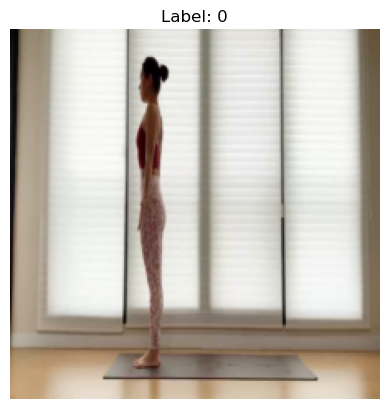

(tensor([[[[-2.0152, -1.9467, -2.0323,  ..., -0.4054, -0.4226, -0.4226],
           [-2.0152, -1.9467, -2.0323,  ..., -0.4054, -0.4226, -0.4226],
           [-2.0152, -1.9467, -2.0323,  ..., -0.4054, -0.4226, -0.4226],
           ...,
           [ 1.1358,  1.2043,  1.2557,  ...,  0.7248,  0.6906,  0.6734],
           [ 1.0844,  1.1529,  1.2385,  ...,  0.7248,  0.6906,  0.6734],
           [ 1.0502,  1.1187,  1.2043,  ...,  0.7248,  0.6906,  0.6734]],
 
          [[-1.9307, -1.8606, -1.9482,  ..., -0.6176, -0.6352, -0.6352],
           [-1.9307, -1.8606, -1.9482,  ..., -0.6176, -0.6352, -0.6352],
           [-1.9307, -1.8606, -1.9482,  ..., -0.6176, -0.6352, -0.6352],
           ...,
           [ 0.6604,  0.7129,  0.7654,  ...,  0.2402,  0.2052,  0.1877],
           [ 0.6078,  0.6604,  0.7304,  ...,  0.2402,  0.2052,  0.1877],
           [ 0.5728,  0.6254,  0.7129,  ...,  0.2402,  0.2052,  0.1877]],
 
          [[-1.6999, -1.6302, -1.7173,  ..., -0.7936, -0.8110, -0.8110],
           [-

In [104]:
# Get data and label from dataset
data, label = dataset[77]

# Print shape of data
print(f"Data shape: {data.shape}")  # Should be (T, C, H, W)

# Get last frame
last_frame = data[-1]

# Denormalize the frame (ResNet normalization parameters)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
denormalized_frame = last_frame * std + mean

# Convert tensor to numpy and permute dimensions for matplotlib
denormalized_frame_np = denormalized_frame.permute(1, 2, 0).numpy()

# Display the last frame
import matplotlib.pyplot as plt
plt.imshow(denormalized_frame_np)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

# Return data and label for further use
data, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Data shape: torch.Size([46, 3, 224, 224])


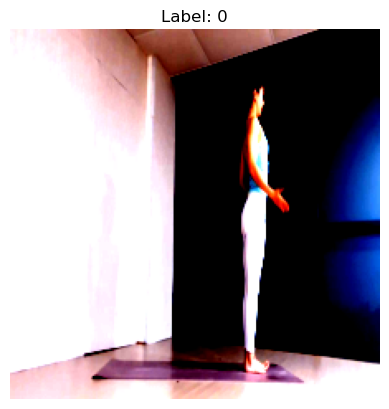

(tensor([[[[ 1.2043,  1.1358,  1.1358,  ..., -1.7925, -1.8097, -1.8097],
           [ 1.2214,  1.1529,  1.1529,  ..., -1.7754, -1.7925, -1.7925],
           [ 1.2043,  1.1700,  1.1872,  ..., -1.7754, -1.7754, -1.7583],
           ...,
           [ 1.1187,  1.1187,  1.1187,  ...,  1.4783,  1.4612,  1.4612],
           [ 1.1358,  1.1358,  1.1358,  ...,  1.5125,  1.4954,  1.4783],
           [ 1.1358,  1.1529,  1.1358,  ...,  1.5297,  1.5125,  1.5125]],
 
          [[ 0.9755,  0.9405,  0.9405,  ..., -1.6155, -1.6331, -1.6331],
           [ 0.9930,  0.9580,  0.9580,  ..., -1.6155, -1.6155, -1.6155],
           [ 0.9930,  0.9755,  0.9930,  ..., -1.5980, -1.5980, -1.5805],
           ...,
           [ 0.8529,  0.8529,  0.8529,  ...,  1.3782,  1.3606,  1.3606],
           [ 0.8704,  0.8704,  0.8704,  ...,  1.4132,  1.3957,  1.3782],
           [ 0.8704,  0.8880,  0.8704,  ...,  1.4307,  1.4132,  1.4132]],
 
          [[ 0.9319,  0.9319,  0.9668,  ..., -1.4036, -1.4210, -1.4210],
           [ 

In [88]:
# Get data and label from dataset
data, label = dataset[101]

# Print shape of data
print(f"Data shape: {data.shape}")  # Should be (T, C, H, W)

# Get last frame
last_frame = data[-1]

# Convert tensor to numpy and permute dimensions for matplotlib
frame_np = last_frame.permute(1, 2, 0).numpy()

# Display the last frame
import matplotlib.pyplot as plt
plt.imshow(frame_np)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

# Return data and label for further use
data, label